In [1]:
import os
import sys
from pprint import pprint
sys.path.append('../')

import torch
from transformers import BertTokenizer

from modules import ssd
from run_ner_ssd import ClueNerProcessor, NerDataset, Example2Feature

### Load Examples

In [2]:
data_dir = '../CLUENER2000/'
train_file = 'train.json'
dev_file   = 'dev.json'
test_file  = 'test.json'
max_seq_length = 256

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True, cache_dir=None)
processor = ClueNerProcessor()
process_pipline = [
    Example2Feature(tokenizer, processor.label2id, max_seq_length),
]

train_examples = processor.get_train_examples(data_dir, train_file)
dev_examples = processor.get_train_examples(data_dir, dev_file)
test_examples = processor.get_train_examples(data_dir, test_file)

train_dataset = NerDataset(train_examples, process_pipline)
dev_dataset = NerDataset(dev_examples, process_pipline)
test_dataset = NerDataset(test_examples, process_pipline)

In [3]:
processor.label2id

{'X': 0,
 'O': 1,
 '[START]': 2,
 '[END]': 3,
 'address': 4,
 'book': 5,
 'company': 6,
 'game': 7,
 'government': 8,
 'movie': 9,
 'name': 10,
 'organization': 11,
 'position': 12,
 'scene': 13}

In [4]:
print(train_examples[0])

(0, {'id': 'train-0', 'tokens': ['浙', '商', '银', '行', '企', '业', '信', '贷', '部', '叶', '老', '桂', '博', '士', '则', '从', '另', '一', '个', '角', '度', '对', '五', '道', '门', '槛', '进', '行', '了', '解', '读', '。', '叶', '老', '桂', '认', '为', '，', '对', '目', '前', '国', '内', '商', '业', '银', '行', '而', '言', '，'], 'entities': [('company', 0, 3), ('name', 9, 11)]})


In [5]:
print([(token_no, token) for token_no, token in enumerate(['[CLS]'] + train_examples[0][1]["tokens"] + ['[SEP]'])])

[(0, '[CLS]'), (1, '浙'), (2, '商'), (3, '银'), (4, '行'), (5, '企'), (6, '业'), (7, '信'), (8, '贷'), (9, '部'), (10, '叶'), (11, '老'), (12, '桂'), (13, '博'), (14, '士'), (15, '则'), (16, '从'), (17, '另'), (18, '一'), (19, '个'), (20, '角'), (21, '度'), (22, '对'), (23, '五'), (24, '道'), (25, '门'), (26, '槛'), (27, '进'), (28, '行'), (29, '了'), (30, '解'), (31, '读'), (32, '。'), (33, '叶'), (34, '老'), (35, '桂'), (36, '认'), (37, '为'), (38, '，'), (39, '对'), (40, '目'), (41, '前'), (42, '国'), (43, '内'), (44, '商'), (45, '业'), (46, '银'), (47, '行'), (48, '而'), (49, '言'), (50, '，'), (51, '[SEP]')]


In [6]:
print(train_dataset[0])

{'input_ids': tensor([[ 101, 3851, 1555, 7213, 6121,  821,  689,  928, 6587, 6956, 1383, 5439,
         3424, 1300, 1894, 1156,  794, 1369,  671,  702, 6235, 2428, 2190,  758,
         6887, 7305, 3546, 6822, 6121,  749, 6237, 6438,  511, 1383, 5439, 3424,
         6371,  711, 8024, 2190, 4680, 1184, 1744, 1079, 1555,  689, 7213, 6121,
         5445, 6241, 8024,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

### Define SSD

In [7]:
hidden_size = 768
num_labels = len(processor.get_labels())
max_seq_length = max_seq_length
anchor_size = [1, 3, 5, 7]
conf_thresh = 0.5
nms_thresh = 0.6
tag_o = processor.label2id['O']
ssd_header = ssd.SSD(hidden_size, num_labels, max_seq_length, anchor_size, conf_thresh, nms_thresh, tag_o)

In [8]:
anchors_cs = ssd_header.anchors
anchors_lr = torch.stack([ssd.fleft(anchors_cs[..., 0], anchors_cs[..., 1]), 
        ssd.fright(anchors_cs[..., 0], anchors_cs[..., 1])], dim=-1)

In [9]:
anchors_cs.size()

torch.Size([256, 4, 2])

In [10]:
print(anchors_cs[..., 0].numpy().tolist())

[[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5], [6, 6, 6, 6], [7, 7, 7, 7], [8, 8, 8, 8], [9, 9, 9, 9], [10, 10, 10, 10], [11, 11, 11, 11], [12, 12, 12, 12], [13, 13, 13, 13], [14, 14, 14, 14], [15, 15, 15, 15], [16, 16, 16, 16], [17, 17, 17, 17], [18, 18, 18, 18], [19, 19, 19, 19], [20, 20, 20, 20], [21, 21, 21, 21], [22, 22, 22, 22], [23, 23, 23, 23], [24, 24, 24, 24], [25, 25, 25, 25], [26, 26, 26, 26], [27, 27, 27, 27], [28, 28, 28, 28], [29, 29, 29, 29], [30, 30, 30, 30], [31, 31, 31, 31], [32, 32, 32, 32], [33, 33, 33, 33], [34, 34, 34, 34], [35, 35, 35, 35], [36, 36, 36, 36], [37, 37, 37, 37], [38, 38, 38, 38], [39, 39, 39, 39], [40, 40, 40, 40], [41, 41, 41, 41], [42, 42, 42, 42], [43, 43, 43, 43], [44, 44, 44, 44], [45, 45, 45, 45], [46, 46, 46, 46], [47, 47, 47, 47], [48, 48, 48, 48], [49, 49, 49, 49], [50, 50, 50, 50], [51, 51, 51, 51], [52, 52, 52, 52], [53, 53, 53, 53], [54, 54, 54, 54], [55, 55, 55, 55], [56, 56, 56, 56], [57, 57, 57, 

In [11]:
print(anchors_cs[..., 1].numpy().tolist())

[[1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3, 5, 7], [1, 3

In [12]:
print(anchors_lr[..., 0].numpy().tolist())

[[-0.5, -1.5, -2.5, -3.5], [0.5, -0.5, -1.5, -2.5], [1.5, 0.5, -0.5, -1.5], [2.5, 1.5, 0.5, -0.5], [3.5, 2.5, 1.5, 0.5], [4.5, 3.5, 2.5, 1.5], [5.5, 4.5, 3.5, 2.5], [6.5, 5.5, 4.5, 3.5], [7.5, 6.5, 5.5, 4.5], [8.5, 7.5, 6.5, 5.5], [9.5, 8.5, 7.5, 6.5], [10.5, 9.5, 8.5, 7.5], [11.5, 10.5, 9.5, 8.5], [12.5, 11.5, 10.5, 9.5], [13.5, 12.5, 11.5, 10.5], [14.5, 13.5, 12.5, 11.5], [15.5, 14.5, 13.5, 12.5], [16.5, 15.5, 14.5, 13.5], [17.5, 16.5, 15.5, 14.5], [18.5, 17.5, 16.5, 15.5], [19.5, 18.5, 17.5, 16.5], [20.5, 19.5, 18.5, 17.5], [21.5, 20.5, 19.5, 18.5], [22.5, 21.5, 20.5, 19.5], [23.5, 22.5, 21.5, 20.5], [24.5, 23.5, 22.5, 21.5], [25.5, 24.5, 23.5, 22.5], [26.5, 25.5, 24.5, 23.5], [27.5, 26.5, 25.5, 24.5], [28.5, 27.5, 26.5, 25.5], [29.5, 28.5, 27.5, 26.5], [30.5, 29.5, 28.5, 27.5], [31.5, 30.5, 29.5, 28.5], [32.5, 31.5, 30.5, 29.5], [33.5, 32.5, 31.5, 30.5], [34.5, 33.5, 32.5, 31.5], [35.5, 34.5, 33.5, 32.5], [36.5, 35.5, 34.5, 33.5], [37.5, 36.5, 35.5, 34.5], [38.5, 37.5, 36.5, 35.5],

In [13]:
print(anchors_lr[..., 1].numpy().tolist())

[[0.5, 1.5, 2.5, 3.5], [1.5, 2.5, 3.5, 4.5], [2.5, 3.5, 4.5, 5.5], [3.5, 4.5, 5.5, 6.5], [4.5, 5.5, 6.5, 7.5], [5.5, 6.5, 7.5, 8.5], [6.5, 7.5, 8.5, 9.5], [7.5, 8.5, 9.5, 10.5], [8.5, 9.5, 10.5, 11.5], [9.5, 10.5, 11.5, 12.5], [10.5, 11.5, 12.5, 13.5], [11.5, 12.5, 13.5, 14.5], [12.5, 13.5, 14.5, 15.5], [13.5, 14.5, 15.5, 16.5], [14.5, 15.5, 16.5, 17.5], [15.5, 16.5, 17.5, 18.5], [16.5, 17.5, 18.5, 19.5], [17.5, 18.5, 19.5, 20.5], [18.5, 19.5, 20.5, 21.5], [19.5, 20.5, 21.5, 22.5], [20.5, 21.5, 22.5, 23.5], [21.5, 22.5, 23.5, 24.5], [22.5, 23.5, 24.5, 25.5], [23.5, 24.5, 25.5, 26.5], [24.5, 25.5, 26.5, 27.5], [25.5, 26.5, 27.5, 28.5], [26.5, 27.5, 28.5, 29.5], [27.5, 28.5, 29.5, 30.5], [28.5, 29.5, 30.5, 31.5], [29.5, 30.5, 31.5, 32.5], [30.5, 31.5, 32.5, 33.5], [31.5, 32.5, 33.5, 34.5], [32.5, 33.5, 34.5, 35.5], [33.5, 34.5, 35.5, 36.5], [34.5, 35.5, 36.5, 37.5], [35.5, 36.5, 37.5, 38.5], [36.5, 37.5, 38.5, 39.5], [37.5, 38.5, 39.5, 40.5], [38.5, 39.5, 40.5, 41.5], [39.5, 40.5, 41.5, 

### Encode

In [14]:
inputs = NerDataset.collate_fn([train_dataset[0]])

In [15]:
inputs

{'input_ids': tensor([[ 101, 3851, 1555, 7213, 6121,  821,  689,  928, 6587, 6956, 1383, 5439,
          3424, 1300, 1894, 1156,  794, 1369,  671,  702, 6235, 2428, 2190,  758,
          6887, 7305, 3546, 6822, 6121,  749, 6237, 6438,  511, 1383, 5439, 3424,
          6371,  711, 8024, 2190, 4680, 1184, 1744, 1079, 1555,  689, 7213, 6121,
          5445, 6241, 8024,  102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]]),
 'input_len': tensor([52]),
 'label': tensor([[ 6.0000,  0.5000,  4.5000],
         [10.0000,  9.5000, 12.5000]]),
 'index': tensor([0, 0], dtype=torch.int32)}

In [16]:
print(inputs['label'][[0], 1:])
ious = ssd.iou(anchors_lr.view(-1, 2), inputs['label'][[0], 1:]).numpy().tolist()
for iou_, anchor_lr_, anchor_cs_ in zip(ious, anchors_lr.view(-1, 2).numpy().tolist(), anchors_cs.view(-1, 2).numpy().tolist()):
    print(iou_, anchor_lr_, anchor_cs_)

tensor([[0.5000, 4.5000]])
[0.0] [-0.5, 0.5] [0, 1]
[0.1666666716337204] [-1.5, 1.5] [0, 3]
[0.2857142984867096] [-2.5, 2.5] [0, 5]
[0.375] [-3.5, 3.5] [0, 7]
[0.25] [0.5, 1.5] [1, 1]
[0.4000000059604645] [-0.5, 2.5] [1, 3]
[0.5] [-1.5, 3.5] [1, 5]
[0.5714285969734192] [-2.5, 4.5] [1, 7]
[0.25] [1.5, 2.5] [2, 1]
[0.75] [0.5, 3.5] [2, 3]
[0.800000011920929] [-0.5, 4.5] [2, 5]
[0.5714285969734192] [-1.5, 5.5] [2, 7]
[0.25] [2.5, 3.5] [3, 1]
[0.75] [1.5, 4.5] [3, 3]
[0.800000011920929] [0.5, 5.5] [3, 5]
[0.5714285969734192] [-0.5, 6.5] [3, 7]
[0.25] [3.5, 4.5] [4, 1]
[0.4000000059604645] [2.5, 5.5] [4, 3]
[0.5] [1.5, 6.5] [4, 5]
[0.5714285969734192] [0.5, 7.5] [4, 7]
[0.0] [4.5, 5.5] [5, 1]
[0.1666666716337204] [3.5, 6.5] [5, 3]
[0.2857142984867096] [2.5, 7.5] [5, 5]
[0.375] [1.5, 8.5] [5, 7]
[0.0] [5.5, 6.5] [6, 1]
[0.0] [4.5, 7.5] [6, 3]
[0.125] [3.5, 8.5] [6, 5]
[0.2222222238779068] [2.5, 9.5] [6, 7]
[0.0] [6.5, 7.5] [7, 1]
[0.0] [5.5, 8.5] [7, 3]
[0.0] [4.5, 9.5] [7, 5]
[0.10000000149

[0.0] [102.5, 105.5] [104, 3]
[0.0] [101.5, 106.5] [104, 5]
[0.0] [100.5, 107.5] [104, 7]
[0.0] [104.5, 105.5] [105, 1]
[0.0] [103.5, 106.5] [105, 3]
[0.0] [102.5, 107.5] [105, 5]
[0.0] [101.5, 108.5] [105, 7]
[0.0] [105.5, 106.5] [106, 1]
[0.0] [104.5, 107.5] [106, 3]
[0.0] [103.5, 108.5] [106, 5]
[0.0] [102.5, 109.5] [106, 7]
[0.0] [106.5, 107.5] [107, 1]
[0.0] [105.5, 108.5] [107, 3]
[0.0] [104.5, 109.5] [107, 5]
[0.0] [103.5, 110.5] [107, 7]
[0.0] [107.5, 108.5] [108, 1]
[0.0] [106.5, 109.5] [108, 3]
[0.0] [105.5, 110.5] [108, 5]
[0.0] [104.5, 111.5] [108, 7]
[0.0] [108.5, 109.5] [109, 1]
[0.0] [107.5, 110.5] [109, 3]
[0.0] [106.5, 111.5] [109, 5]
[0.0] [105.5, 112.5] [109, 7]
[0.0] [109.5, 110.5] [110, 1]
[0.0] [108.5, 111.5] [110, 3]
[0.0] [107.5, 112.5] [110, 5]
[0.0] [106.5, 113.5] [110, 7]
[0.0] [110.5, 111.5] [111, 1]
[0.0] [109.5, 112.5] [111, 3]
[0.0] [108.5, 113.5] [111, 5]
[0.0] [107.5, 114.5] [111, 7]
[0.0] [111.5, 112.5] [112, 1]
[0.0] [110.5, 113.5] [112, 3]
[0.0] [109

[0.0] [176.5, 181.5] [179, 5]
[0.0] [175.5, 182.5] [179, 7]
[0.0] [179.5, 180.5] [180, 1]
[0.0] [178.5, 181.5] [180, 3]
[0.0] [177.5, 182.5] [180, 5]
[0.0] [176.5, 183.5] [180, 7]
[0.0] [180.5, 181.5] [181, 1]
[0.0] [179.5, 182.5] [181, 3]
[0.0] [178.5, 183.5] [181, 5]
[0.0] [177.5, 184.5] [181, 7]
[0.0] [181.5, 182.5] [182, 1]
[0.0] [180.5, 183.5] [182, 3]
[0.0] [179.5, 184.5] [182, 5]
[0.0] [178.5, 185.5] [182, 7]
[0.0] [182.5, 183.5] [183, 1]
[0.0] [181.5, 184.5] [183, 3]
[0.0] [180.5, 185.5] [183, 5]
[0.0] [179.5, 186.5] [183, 7]
[0.0] [183.5, 184.5] [184, 1]
[0.0] [182.5, 185.5] [184, 3]
[0.0] [181.5, 186.5] [184, 5]
[0.0] [180.5, 187.5] [184, 7]
[0.0] [184.5, 185.5] [185, 1]
[0.0] [183.5, 186.5] [185, 3]
[0.0] [182.5, 187.5] [185, 5]
[0.0] [181.5, 188.5] [185, 7]
[0.0] [185.5, 186.5] [186, 1]
[0.0] [184.5, 187.5] [186, 3]
[0.0] [183.5, 188.5] [186, 5]
[0.0] [182.5, 189.5] [186, 7]
[0.0] [186.5, 187.5] [187, 1]
[0.0] [185.5, 188.5] [187, 3]
[0.0] [184.5, 189.5] [187, 5]
[0.0] [183

In [17]:
print(inputs['label'][[1], 1:])
ious = ssd.iou(anchors_lr.view(-1, 2), inputs['label'][[1], 1:]).numpy().tolist()
for iou_, anchor_lr_, anchor_cs_ in zip(ious, anchors_lr.view(-1, 2).numpy().tolist(), anchors_cs.view(-1, 2).numpy().tolist()):
    print(iou_, anchor_lr_, anchor_cs_)

tensor([[ 9.5000, 12.5000]])
[0.0] [-0.5, 0.5] [0, 1]
[0.0] [-1.5, 1.5] [0, 3]
[0.0] [-2.5, 2.5] [0, 5]
[0.0] [-3.5, 3.5] [0, 7]
[0.0] [0.5, 1.5] [1, 1]
[0.0] [-0.5, 2.5] [1, 3]
[0.0] [-1.5, 3.5] [1, 5]
[0.0] [-2.5, 4.5] [1, 7]
[0.0] [1.5, 2.5] [2, 1]
[0.0] [0.5, 3.5] [2, 3]
[0.0] [-0.5, 4.5] [2, 5]
[0.0] [-1.5, 5.5] [2, 7]
[0.0] [2.5, 3.5] [3, 1]
[0.0] [1.5, 4.5] [3, 3]
[0.0] [0.5, 5.5] [3, 5]
[0.0] [-0.5, 6.5] [3, 7]
[0.0] [3.5, 4.5] [4, 1]
[0.0] [2.5, 5.5] [4, 3]
[0.0] [1.5, 6.5] [4, 5]
[0.0] [0.5, 7.5] [4, 7]
[0.0] [4.5, 5.5] [5, 1]
[0.0] [3.5, 6.5] [5, 3]
[0.0] [2.5, 7.5] [5, 5]
[0.0] [1.5, 8.5] [5, 7]
[0.0] [5.5, 6.5] [6, 1]
[0.0] [4.5, 7.5] [6, 3]
[0.0] [3.5, 8.5] [6, 5]
[0.0] [2.5, 9.5] [6, 7]
[0.0] [6.5, 7.5] [7, 1]
[0.0] [5.5, 8.5] [7, 3]
[0.0] [4.5, 9.5] [7, 5]
[0.1111111119389534] [3.5, 10.5] [7, 7]
[0.0] [7.5, 8.5] [8, 1]
[0.0] [6.5, 9.5] [8, 3]
[0.1428571492433548] [5.5, 10.5] [8, 5]
[0.25] [4.5, 11.5] [8, 7]
[0.0] [8.5, 9.5] [9, 1]
[0.20000000298023224] [7.5, 10.5] [9, 3

[0.0] [105.5, 110.5] [108, 5]
[0.0] [104.5, 111.5] [108, 7]
[0.0] [108.5, 109.5] [109, 1]
[0.0] [107.5, 110.5] [109, 3]
[0.0] [106.5, 111.5] [109, 5]
[0.0] [105.5, 112.5] [109, 7]
[0.0] [109.5, 110.5] [110, 1]
[0.0] [108.5, 111.5] [110, 3]
[0.0] [107.5, 112.5] [110, 5]
[0.0] [106.5, 113.5] [110, 7]
[0.0] [110.5, 111.5] [111, 1]
[0.0] [109.5, 112.5] [111, 3]
[0.0] [108.5, 113.5] [111, 5]
[0.0] [107.5, 114.5] [111, 7]
[0.0] [111.5, 112.5] [112, 1]
[0.0] [110.5, 113.5] [112, 3]
[0.0] [109.5, 114.5] [112, 5]
[0.0] [108.5, 115.5] [112, 7]
[0.0] [112.5, 113.5] [113, 1]
[0.0] [111.5, 114.5] [113, 3]
[0.0] [110.5, 115.5] [113, 5]
[0.0] [109.5, 116.5] [113, 7]
[0.0] [113.5, 114.5] [114, 1]
[0.0] [112.5, 115.5] [114, 3]
[0.0] [111.5, 116.5] [114, 5]
[0.0] [110.5, 117.5] [114, 7]
[0.0] [114.5, 115.5] [115, 1]
[0.0] [113.5, 116.5] [115, 3]
[0.0] [112.5, 117.5] [115, 5]
[0.0] [111.5, 118.5] [115, 7]
[0.0] [115.5, 116.5] [116, 1]
[0.0] [114.5, 117.5] [116, 3]
[0.0] [113.5, 118.5] [116, 5]
[0.0] [112

[0.0] [199.5, 204.5] [202, 5]
[0.0] [198.5, 205.5] [202, 7]
[0.0] [202.5, 203.5] [203, 1]
[0.0] [201.5, 204.5] [203, 3]
[0.0] [200.5, 205.5] [203, 5]
[0.0] [199.5, 206.5] [203, 7]
[0.0] [203.5, 204.5] [204, 1]
[0.0] [202.5, 205.5] [204, 3]
[0.0] [201.5, 206.5] [204, 5]
[0.0] [200.5, 207.5] [204, 7]
[0.0] [204.5, 205.5] [205, 1]
[0.0] [203.5, 206.5] [205, 3]
[0.0] [202.5, 207.5] [205, 5]
[0.0] [201.5, 208.5] [205, 7]
[0.0] [205.5, 206.5] [206, 1]
[0.0] [204.5, 207.5] [206, 3]
[0.0] [203.5, 208.5] [206, 5]
[0.0] [202.5, 209.5] [206, 7]
[0.0] [206.5, 207.5] [207, 1]
[0.0] [205.5, 208.5] [207, 3]
[0.0] [204.5, 209.5] [207, 5]
[0.0] [203.5, 210.5] [207, 7]
[0.0] [207.5, 208.5] [208, 1]
[0.0] [206.5, 209.5] [208, 3]
[0.0] [205.5, 210.5] [208, 5]
[0.0] [204.5, 211.5] [208, 7]
[0.0] [208.5, 209.5] [209, 1]
[0.0] [207.5, 210.5] [209, 3]
[0.0] [206.5, 211.5] [209, 5]
[0.0] [205.5, 212.5] [209, 7]
[0.0] [209.5, 210.5] [210, 1]
[0.0] [208.5, 211.5] [210, 3]
[0.0] [207.5, 212.5] [210, 5]
[0.0] [206

In [18]:
iou_thresh_pos = 0.6
iou_thresh_neg = 0.2
conf_label, cls_label, reg_label = ssd.encode(
    batch_size=1, sequence_length=max_seq_length,
    input_len=inputs['input_len'],
    label=inputs['label'],
    index=inputs['index'],
    anchors=anchors_cs,
    iou_thresh_pos=iou_thresh_pos,
    iou_thresh_neg=iou_thresh_neg,
    ignore_index=-100,
)

In [19]:
conf_label.size()

torch.Size([1, 256, 4])

In [20]:
for row, anchor in zip(conf_label[0], anchors_cs):
    print(row, anchor[:, 0], anchor[:, 1])

tensor([-100.,    0., -100., -100.]) tensor([0, 0, 0, 0]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([1, 1, 1, 1]) tensor([1, 3, 5, 7])
tensor([-100.,    1.,    1., -100.]) tensor([2, 2, 2, 2]) tensor([1, 3, 5, 7])
tensor([-100.,    1.,    1., -100.]) tensor([3, 3, 3, 3]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([4, 4, 4, 4]) tensor([1, 3, 5, 7])
tensor([-100.,    0., -100., -100.]) tensor([5, 5, 5, 5]) tensor([1, 3, 5, 7])
tensor([-100., -100.,    0., -100.]) tensor([6, 6, 6, 6]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100.,    0.]) tensor([7, 7, 7, 7]) tensor([1, 3, 5, 7])
tensor([-100., -100.,    0., -100.]) tensor([8, 8, 8, 8]) tensor([1, 3, 5, 7])
tensor([-100.,    0., -100., -100.]) tensor([9, 9, 9, 9]) tensor([1, 3, 5, 7])
tensor([-100., -100.,    1., -100.]) tensor([10, 10, 10, 10]) tensor([1, 3, 5, 7])
tensor([-100.,    1.,    1., -100.]) tensor([11, 11, 11, 11]) tensor([1, 3, 5, 7])
tensor([-100., -100.,    1., -100.]) tensor(

tensor([-100., -100., -100., -100.]) tensor([104, 104, 104, 104]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([105, 105, 105, 105]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([106, 106, 106, 106]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([107, 107, 107, 107]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([108, 108, 108, 108]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([109, 109, 109, 109]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([110, 110, 110, 110]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([111, 111, 111, 111]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([112, 112, 112, 112]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([113, 113, 113, 113]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([114, 114, 114, 114]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor

tensor([-100., -100., -100., -100.]) tensor([205, 205, 205, 205]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([206, 206, 206, 206]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([207, 207, 207, 207]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([208, 208, 208, 208]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([209, 209, 209, 209]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([210, 210, 210, 210]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([211, 211, 211, 211]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([212, 212, 212, 212]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([213, 213, 213, 213]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([214, 214, 214, 214]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor([215, 215, 215, 215]) tensor([1, 3, 5, 7])
tensor([-100., -100., -100., -100.]) tensor

In [21]:
cls_label.size()

torch.Size([1, 256, 4])

In [22]:
for row in cls_label[0]:
    print(row)

tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100,    6,    6, -100])
tensor([-100,    6,    6, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100,   10, -100])
tensor([-100,   10,   10, -100])
tensor([-100, -100,   10, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-100, -100, -100, -100])
tensor([-1

In [23]:
reg_label.size()

torch.Size([1, 256, 4, 2])

In [24]:
reg_label[conf_label == 1].size()

torch.Size([8, 2])

In [25]:
for row in reg_label[0]:
    print(row[..., 0])

tensor([2.5000, 0.8333, 0.5000, 0.3571])
tensor([1.5000, 0.5000, 0.3000, 0.2143])
tensor([0.5000, 0.1667, 0.1000, 0.0714])
tensor([-0.5000, -0.1667, -0.1000, -0.0714])
tensor([-1.5000, -0.5000, -0.3000, -0.2143])
tensor([-2.5000, -0.8333, -0.5000, -0.3571])
tensor([-3.5000, -1.1667, -0.7000, -0.5000])
tensor([-4.5000, -1.5000, -0.9000,  0.5714])
tensor([-5.5000, -1.8333,  0.6000,  0.4286])
tensor([-6.5000,  0.6667,  0.4000,  0.2857])
tensor([1.0000, 0.3333, 0.2000, 0.1429])
tensor([0., 0., 0., 0.])
tensor([-1.0000, -0.3333, -0.2000, -0.1429])
tensor([-10.5000,  -0.6667,  -0.4000,  -0.2857])
tensor([-11.5000,  -3.8333,  -0.6000,  -0.4286])
tensor([-12.5000,  -4.1667,  -2.5000,  -0.5714])
tensor([-13.5000,  -4.5000,  -2.7000,  -1.9286])
tensor([-14.5000,  -4.8333,  -2.9000,  -2.0714])
tensor([-15.5000,  -5.1667,  -3.1000,  -2.2143])
tensor([-16.5000,  -5.5000,  -3.3000,  -2.3571])
tensor([-17.5000,  -5.8333,  -3.5000,  -2.5000])
tensor([-18.5000,  -6.1667,  -3.7000,  -2.6429])
tensor([-1

In [26]:
for row in reg_label[0]:
    print(row[..., 1])

tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.4286])
tensor([4.0000, 1.3333, 0.6000, 0.4286])
tensor([4.0000, 1.0000, 0.6000, 0.4286])
tensor([3.0000, 1.0000, 0.6000, 0.4286])
tensor([3.0000, 1.0000, 0.6000, 0.4286])
tensor([3.0000, 1.0000, 0.6000, 0.4286])
tensor([4.0000, 1.0000, 0.6000, 0.4286])
tensor([4.0000, 1.3333, 0.6000, 0.4286])
tensor([4.0000, 1.3333, 0.8000, 0.4286])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 1.3333, 0.8000, 0.5714])
tensor([4.0000, 

### Anchor尺寸和实体尺寸的关系

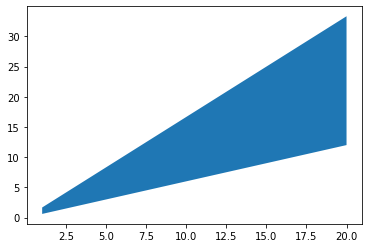

In [27]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

rel_iou_thresh_pos = 0.6
rel_iou_thresh_neg = 0.3
rel_anchor_size = np.arange(20) + 1
rel_entity_size = np.arange(20) + 1

rel_anchor_longest_to_pred = rel_anchor_size / rel_iou_thresh_pos
rel_anchor_shortest_to_pred = rel_anchor_size * rel_iou_thresh_pos
plt.figure()
plt.fill_between(rel_anchor_size, rel_anchor_shortest_to_pred, rel_anchor_longest_to_pred)
plt.show()

In [28]:
rel_anchor_range_to_pred = np.stack([rel_anchor_size, rel_anchor_shortest_to_pred, rel_anchor_longest_to_pred], axis=-1)
print(rel_anchor_range_to_pred)

[[ 1.          0.6         1.66666667]
 [ 2.          1.2         3.33333333]
 [ 3.          1.8         5.        ]
 [ 4.          2.4         6.66666667]
 [ 5.          3.          8.33333333]
 [ 6.          3.6        10.        ]
 [ 7.          4.2        11.66666667]
 [ 8.          4.8        13.33333333]
 [ 9.          5.4        15.        ]
 [10.          6.         16.66666667]
 [11.          6.6        18.33333333]
 [12.          7.2        20.        ]
 [13.          7.8        21.66666667]
 [14.          8.4        23.33333333]
 [15.          9.         25.        ]
 [16.          9.6        26.66666667]
 [17.         10.2        28.33333333]
 [18.         10.8        30.        ]
 [19.         11.4        31.66666667]
 [20.         12.         33.33333333]]


In [29]:
rel_entity_anchor_match = []
for rez in rel_entity_size:
    rel_entity_anchor_match.append(
        (rez >= rel_anchor_range_to_pred[:, 0]) & (rez <= rel_anchor_range_to_pred[:, 1]))
rel_entity_anchor_match = np.stack(rel_entity_anchor_match).astype(np.int)
print(rel_entity_anchor_match)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### 数据分布

In [30]:
inputs = NerDataset.collate_fn(list(train_dataset))

In [31]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'input_len', 'label', 'index'])

In [32]:
inputs['label'].size()

torch.Size([23973, 3])

In [33]:
inputs['index']

tensor([    0,     0,     1,  ..., 10746, 10747, 10747], dtype=torch.int32)

In [34]:
inputs['input_ids'].size()

torch.Size([10748, 52])

In [35]:
entity_types = inputs['label'][:, 0]
entity_left = inputs['label'][:, 1]
entity_right = inputs['label'][:, 2]
entity_size = ssd.fsize(entity_left, entity_right)

Counter({10: 3755, 11: 3210, 12: 3141, 6: 2980, 4: 2891, 7: 2376, 8: 1835, 13: 1521, 5: 1141, 9: 1123})
[[   1   23]
 [   2 6440]
 [   3 5531]
 [   4 4161]
 [   5 1983]
 [   6 1847]
 [   7 1133]
 [   8  778]
 [   9  440]
 [  10  399]
 [  11  323]
 [  12  193]
 [  13  149]
 [  14  124]
 [  15  110]
 [  16   71]
 [  17   37]
 [  18   57]
 [  19   34]
 [  20   30]
 [  21   18]
 [  22   17]
 [  23   20]
 [  24    9]
 [  25   11]
 [  26    5]
 [  27    7]
 [  28    4]
 [  29    6]
 [  30    6]
 [  32    2]
 [  33    2]
 [  41    2]
 [  44    1]]


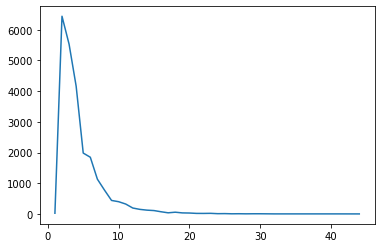

In [36]:
from collections import Counter
type_counter = Counter(entity_types.numpy().astype(np.int).tolist())
print(type_counter)

size_counter = Counter(entity_size.numpy().astype(np.int).tolist())
xy = np.array(sorted(size_counter.items(), key=lambda x: x[0]))
print(xy)
plt.figure()
plt.plot(xy[:, 0], xy[:, 1])
plt.show()

In [37]:
from sklearn.cluster import KMeans
sizes = entity_size.numpy()[:, None]
kmeans = KMeans(n_clusters=10).fit(sizes)
pprint(sorted(kmeans.cluster_centers_[:, 0].tolist()))

[1.9964027404785156,
 3.0000083446502686,
 4.000001907348633,
 5.000001430511475,
 6.38020133972168,
 8.361242294311523,
 11.086472511291504,
 15.481193542480469,
 21.215824127197266,
 29.742856979370117]


In [38]:
from modules import ssd

iou_thresh_pos = 0.5
iou_thresh_neg = 0.25
hidden_size = 768
num_labels = len(processor.get_labels())
max_seq_length = max_seq_length
# anchor_size = [1, 3, 5, 7]
# anchor_size = [i + 1 for i in range(10)]
# anchor_size = [1] + sorted(kmeans.cluster_centers_[:, 0][:-2].tolist())
anchor_size = [1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15]

conf_thresh = 0.5
nms_thresh = 0.6
tag_o = processor.label2id['O']
ssd_header = ssd.SSD(hidden_size, num_labels, max_seq_length, anchor_size, conf_thresh, nms_thresh, tag_o)

conf_label, cls_label, reg_label, states = ssd_header.state(
    inputs, iou_thresh_pos, iou_thresh_neg)

In [39]:
conf_label.size()

torch.Size([10748, 52, 11])

In [40]:
states

{'iou_thresh_pos': 0.5,
 'iou_thresh_neg': 0.25,
 'num_total': 6147856,
 'num_pos': 469414,
 'num_neg': 935882,
 'anchor_size': [1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15],
 'num_pos_each_size': [12903,
  26756,
  51132,
  57643,
  59945,
  62718,
  55666,
  45105,
  39770,
  31853,
  25923],
 'num_neg_each_size': [77719,
  78363,
  60790,
  60461,
  49502,
  65080,
  89691,
  85987,
  92147,
  135006,
  141136],
 'ratio_pos': 0.07635409807907016,
 'ratio_neg': 0.15222900471318782,
 'pos_vs_neg': 0.5015739163697988}